In [1]:
import argparse
from argparse import ArgumentParser


import datetime
import os
import numpy as np

import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from gsae.utils import eval_metrics
from gsae.data_processing.load_splits import load_seq3
from gsae.models.gsae_model import GSAE

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


%matplotlib inline

## 1. Import data

Let's import the SEQ3 data. We can do this using load_seq3 function

it will look for the data in 'data/final_data/' and return the following

- **train_loader**: pytorch dataloader with training data
- **train_tup**: tuple of train coefficients and energies
- **test_tup**: tuple of test coefficients and energies


In [2]:
# train_loader: 
train_loader, train_tup, test_tup = load_seq3()

# 2. Load Model

In [3]:
# set up hyperparameters

input_dim = train_tup[0].shape[-1]
len_epoch = len(train_loader)

hparams = {
    'input_dim':  input_dim,
    'bottle_dim': 25,
    'hidden_dim': 400,
    
    'len_epoch': len_epoch,
    'learning_rate': 0.0001,
    'max_epochs': 80,
    'n_gpus': 0,
    'batch_size': 100,
    
    'alpha':1.0,
    'beta':0.0001,

}

In [4]:
hparams = argparse.Namespace(**hparams)

In [5]:
model = GSAE(hparams)

In [6]:
print(model)

GSAE(
  (fc11): Linear(in_features=2560, out_features=400, bias=True)
  (bn11): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=400, out_features=400, bias=True)
  (bn12): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=25, bias=True)
  (fc22): Linear(in_features=400, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=2560, bias=True)
  (regfc1): Linear(in_features=25, out_features=20, bias=True)
  (regfc2): Linear(in_features=20, out_features=1, bias=True)
)


# 3. Train Model

In [7]:
trainer = pl.Trainer.from_argparse_args(hparams,
                                            max_epochs=hparams.max_epochs,
                                             gpus=hparams.n_gpus,
                                            )
trainer.fit(model=model,
            train_dataloader=train_loader,
            )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/ec_lab/opt/anaconda3/envs/gsae_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name   | Type        | Params
---------------------------------------
0 | fc11   | Linear      | 1 M   
1 | bn11   | BatchNorm1d | 800   
2 | fc12   | Linear      | 160 K 
3 | bn12   | BatchNorm1d | 800   
4 | fc21   | Linear      | 10 K  
5 | fc22   | Linear      | 10 K  
6 | fc3    | Linear      | 10 K  
7 | fc4    | Linear      | 1 M   
8 | regfc1 | Linear      | 520   
9 | regfc2 | Linear      | 21    


Validation sanity check: 0it [00:00, ?it/s]

/Users/ec_lab/opt/anaconda3/envs/gsae_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

1

# 4. Get Embeddings

In [8]:
with torch.no_grad():
        train_embed = model.embed(train_tup[0])[0]
        test_embed =  model.embed(test_tup[0])[0]

In [9]:
print(train_embed.shape)
print(test_embed.shape)

torch.Size([28354, 25])
torch.Size([12153, 25])


# 5. Visualize

In [10]:
pca_coords = PCA(n_components=2).fit_transform(train_embed)

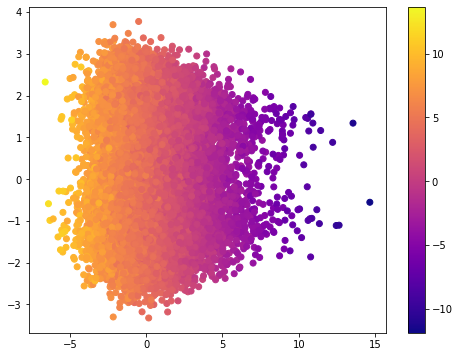

In [11]:
fig,ax = plt.subplots(figsize=(8,6))

im = ax.scatter(pca_coords[:,0],
          pca_coords[:,1],
          c=train_tup[-1], 
          cmap='plasma')

plt.colorbar(im)

# 6.

In [12]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from networkx.drawing.nx_pylab import draw_networkx
from networkx.drawing.layout import kamada_kawai_layout


In [13]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(train_embed)
distances, indices = nbrs.kneighbors(train_embed)

In [17]:
# 10 NN of first entry
ex_neighborhood_inds = indices[1000]
print(ex_neighborhood_inds)

[ 1000  5544 23744  1312 15460 23191 15063 14638 24155  2099]


In [18]:
train_adj = load_seq3(gnn=True)[1][1]
ex_neighborhood_adjs = [train_adj[x].numpy() for x in ex_neighborhood_inds]
ex_neighborhood_graphs = [nx.convert_matrix.from_numpy_matrix(x) for x in ex_neighborhood_adjs]

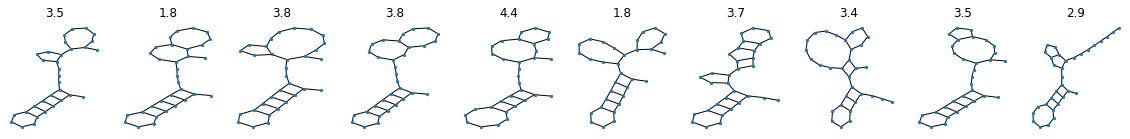

In [20]:
fig, ax = plt.subplots(1,10, figsize=(20,2))

for i, g in enumerate(ex_neighborhood_graphs):
    ppos = kamada_kawai_layout(g)
    nx.draw(g, ax=ax[i], node_size=5, pos=ppos)
    ax[i].title.set_text('{:.2}'.format(train_tup[-1][ex_neighborhood_inds[i]].item()))
    